In [72]:
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
from functools import (partial, reduce)
import networkx as nx
import scipy
from sklearn import manifold

from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)

from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap

from sklearn.preprocessing import scale, normalize

In [73]:
grid_width = 3
grid_height = 3
node_size = 50
OPPORTUNITY_PERCENT = 0.5 # suffices for 3x3->3 grid
num_combinations = 10

graph = nx.grid_graph([grid_width , grid_height])
# #####PLOT GRIDS
initial_assignment = {x: x[0] for x in graph.nodes()}
graph = nx.relabel.convert_node_labels_to_integers(graph)        
# build initial_assignment
relabeled_assignment = list(initial_assignment.values())
initial_assignment = dict()
for i in range(len(graph.nodes)):
    initial_assignment[i] = relabeled_assignment[i]

    
    
# red is the minority
# red_nodes = [(1,1),(1,2),(2,1),(2,2)]
red_nodes = [3,4,6,7]

for node in graph.nodes():
    graph.node[node]["population"] = 1
    
    if node in red_nodes:
        graph.node[node]["red"]=1
        graph.node[node]["black"]=0
    else:
        graph.node[node]["red"]=0
        graph.node[node]["black"]=1
        




# color_dict = {1: "red", 0: "black"}

# plt.figure()
# nx.draw(
#     graph,
#     pos={x: x for x in graph.nodes()},
#     node_color=[color_dict[graph.node[x]["red"]] for x in graph.nodes()],
#     node_size=node_size,
#     node_shape="s",
# )
# plt.show()

In [74]:
### find a way to compare partitions
### run a chain and get the 10 districts
### pass it to JN's thing

def count_gingles_districts(partition):
    num_gingles_districts = 0

    for district in partition.parts.keys():
        # count minority nodes
        minority_nodes = 0
        for node in partition.parts[district]:
            if graph.nodes[node]["red"] == 1:
                minority_nodes += 1
                
        if minority_nodes / len(partition.parts.keys()) > OPPORTUNITY_PERCENT:
            num_gingles_districts += 1
            
    return num_gingles_districts
        
    
updaters = {
    "population": Tally("population"),
    "num_gingles_districts": count_gingles_districts,
    "cut_edges": cut_edges
}
    
    
grid_partition = Partition(graph, assignment=initial_assignment, updaters=updaters)

# ADD CONSTRAINTS
popbound = within_percent_of_ideal_population(grid_partition, 0.1)

# ########Setup Proposal
ideal_population = sum(grid_partition["population"].values()) / len(grid_partition)

tree_proposal = partial(
    recom,
    pop_col="population",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=1,
)

boundary_chain = MarkovChain(
    tree_proposal,
    Validator([single_flip_contiguous, popbound]),
    accept=always_accept,
    initial_state=grid_partition,
    total_steps=100,
)

In [75]:
# store the partitions in a list
partition_list = []
gingles_scores = []

# run the chain
for current_partition in boundary_chain:

    seen_before = False
    # check if you have seen the partition already
    for seen_partition in partition_list:
        
        # TODO: nasty code that needs to be rewritten
        seen_list = seen_partition.parts.values()
        seen_list = [sorted(list(unit)) for unit in seen_list]
        seen_list = sorted(seen_list)
        
        curr_list = current_partition.parts.values()
        curr_list = [sorted(list(unit)) for unit in curr_list]
        curr_list = sorted(curr_list)
        
        if seen_list == curr_list:
            seen_before = True
            break
    
    if not seen_before:
        gingles_scores.append(current_partition["num_gingles_districts"])
        # if haven't seen the partition before, we want to keep it
        partition_list.append(current_partition)
        
        
    if len(partition_list) == num_combinations:
        break

print(len(partition_list))

10


IndexError: too many indices for array

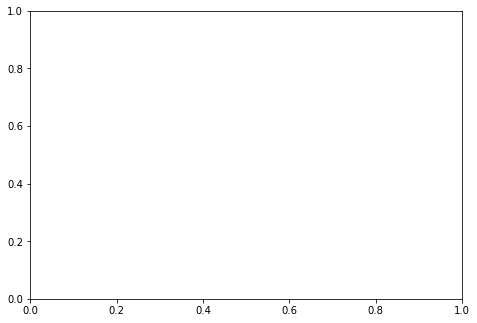

In [16]:
##################################################################################################
####################### SANITY CHECK TO VISUALIZE DISTRICT UNIQUENESS ############################
##################################################################################################

color_dict = {0: "blue", 1: "green", 2: "red"}

for partition in partition_list:
    graph = partition.graph
    
    # figure out the node colors
    assignment = {}
    for x in graph.nodes():
        for key in partition.parts.keys():
            if x in partition.parts[key]:
                assignment[x] = key
    
    plt.figure()
    nx.draw(
        graph,
        pos={x: x for x in graph.nodes()},
        node_color=[color_dict[x] for x in list(assignment.values())],
        node_size=node_size,
        node_shape="s",
    )
    plt.show()
    

In [76]:
def sparse_bound_walk_metric(plan1, plan2):
    score = dir_sparse_bound_walk_metric(plan1, plan2) + dir_sparse_bound_walk_metric(plan2, plan1)
    return score

def dir_sparse_bound_walk_metric(plan1, plan2):
    graph = plan1.graph
    adj = nx.adjacency_matrix(graph, weight=None)
    trans = normalize(adj, norm="l1")
    del adj
    plan1_bound = reduce(lambda ns, e: set(e) | ns, plan1["cut_edges"], set())
    plan2_bound = reduce(lambda ns, e: set(e) | ns, plan2["cut_edges"], set())
    if all(list(map(lambda x: x in plan2_bound, plan1_bound))): return 0

    to_delete = plan2_bound #| contained_by_plan2
    starters = sorted(plan1_bound - to_delete)
    to_delete = list(reversed(sorted(list(to_delete))))
    
    plan1_bound = reduce(lambda shifted, x: list(map(lambda y: y-1 if y > x else y, shifted)), 
                         to_delete, starters)
    P = trans
    del trans
    row_mask = np.ones(P.shape[0], dtype=bool)
    col_mask = np.ones(P.shape[1], dtype=bool)
    row_mask[to_delete] = False
    col_mask[to_delete] = False
    P = P[row_mask][:,col_mask]
    N = scipy.sparse.csr_matrix(scipy.sparse.identity(P.shape[0])) - P
    ones = np.ones((P.shape[0], 1))
    rowsum = scipy.sparse.linalg.spsolve(N, ones)
    
    score = sum([rowsum[i] for i in plan1_bound])
    return score / len(plan1_bound)

In [77]:
##################################################################################################
################################ 2D VISUALIZE ####################################################
##################################################################################################

# Change all the partitions to have graphs that have nodes labeled as integers
def change_node_labels_to_integers(partition_list):
    for partition in partition_list:
        partition.graph = nx.relabel.convert_node_labels_to_integers(partition.graph)        
    return partition_list

partition_list = change_node_labels_to_integers(partition_list)

num_plans = len(partition_list)
a = np.zeros([num_plans, num_plans])
for i in range(num_plans):
    for j in range(num_plans):
        if i > j:
            temp = sparse_bound_walk_metric(partition_list[i], partition_list[j])
            a[i,j] = temp
            a[j,i] = temp

In [78]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=.00001, 
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(a).embedding_

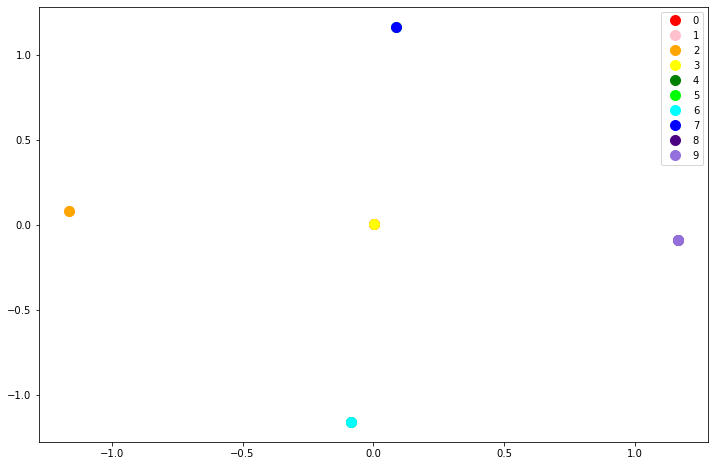

In [79]:
colors = ["red", "pink", "orange", "yellow", "green", "lime", "cyan",
          "blue", "indigo", "mediumpurple", "blueviolet", "purple", "darkmagenta", "fuchsia"]

import time
plt.figure(figsize=(12,8))
for i in range(len(pos)):
    plt.plot(pos[i][0],pos[i][1],'.',label=i, markersize=20, color=colors[i])

plt.xlim()
plt.legend()    
plt.show()

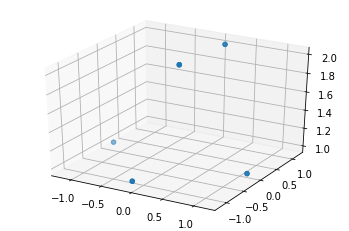

In [83]:
xs = [tup[0] for tup in pos]
ys = [tup[1] for tup in pos]

# just make the z axis for now
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
ax.scatter3D(xs, ys, gingles_scores, cmap='Greens');

In [84]:
# ok so each point is being squished with another

# what is the similarity between these two partitions that makes them squished??

pos

array([[ 7.74741727e-04,  5.01982341e-03],
       [-1.16276997e+00,  8.06692011e-02],
       [-1.16276997e+00,  8.06692011e-02],
       [ 7.74741727e-04,  5.01982341e-03],
       [-8.63221284e-02, -1.15954749e+00],
       [ 8.57912707e-02,  1.16522197e+00],
       [-8.61189216e-02, -1.15956284e+00],
       [ 8.57912707e-02,  1.16522197e+00],
       [ 1.16242448e+00, -9.13558292e-02],
       [ 1.16242448e+00, -9.13558292e-02]])